<h1>Sparse Convolutional Denoising Autoencoders for Genotype Imputation <span class="tocSkip"></span></h1>

### ORIGINAL CODE FROM https://github.com/work-hard-play-harder/SCDA. Just change versiones of libraries or functions names wich have changed

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#Method" data-toc-modified-id="Method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Load-model" data-toc-modified-id="Load-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load model</a></span></li><li><span><a href="#Prediction-on-test-data" data-toc-modified-id="Prediction-on-test-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Prediction on test data</a></span></li></ul></li></ul></div>

# Introduction

This notebook demonstrates a case study of testing a SCDA model on yeast genotype dataset with 10% missing genotypes. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import load_model
import zipfile
import builtins 
import matplotlib.pyplot as plt

# Dataset

## Loading data

In [2]:
def unzip(archivo_zip, variable_name):
    """
    Extrae y carga el contenido del único archivo dentro de un ZIP en una variable global.
    
    Parámetros:
    - archivo_zip: Ruta al archivo ZIP.
    - variable_name: Nombre de la variable global donde se guardará el DataFrame.
    """
    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        # Obtiene directamente el primer (y único) archivo
        file_name = zip_ref.namelist()[0]
        with zip_ref.open(file_name) as txt_file:
            # Leer el archivo como un DataFrame de pandas
            df = pd.read_csv(txt_file, sep='\t', index_col=0)
            
            # Asignar el DataFrame a una variable global con el nombre proporcionado
            builtins.__dict__[variable_name] = df


# Llamar a la función para descomprimir y guardar el df en variable globale
unzip('../../data/raw/yeast_genotype_test.txt.zip', 'df_ori') 

In [3]:
df_ori.head()

,33070_chrI_33070_A_T,33147_chrI_33147_G_T,33152_chrI_33152_T_C,33200_chrI_33200_C_T,33293_chrI_33293_A_T,33328_chrI_33328_C_A,33348_chrI_33348_G_C,33403_chrI_33403_C_T,33502_chrI_33502_A_G,33548_chrI_33548_A_C,...,12048853_chrXVI_925593_G_C,12049199_chrXVI_925939_T_C,12049441_chrXVI_926181_C_T,12050613_chrXVI_927353_T_G,12051167_chrXVI_927907_A_C,12051240_chrXVI_927980_A_G,12051367_chrXVI_928107_C_T,12052782_chrXVI_929522_C_T,12052988_chrXVI_929728_A_G,12053130_chrXVI_929870_C_T
SAMID,,,,,,,,,,,,,,,,,,,,,
40_73,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
40_74,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
40_75,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
40_76,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
40_77,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2


## Preprocessing

In [4]:
# one hot encode
test_X = to_categorical(df_ori)
test_X.shape

(877, 28220, 3)

# Method

## Load model

In [5]:
# returns a compiled model
SCDA = load_model('../../models/SDCA_original/SDCA_yeast.keras')

## Prediction on test data

In [6]:
# hyperparameters
missing_perc = 0.1

In [7]:
test_X_missing = test_X.copy()
test_X_missing.shape

(877, 28220, 3)

In [8]:
def cal_prob(predict_missing_onehot):
    # calcaulate the probility of genotype 0, 1, 2
    predict_prob = predict_missing_onehot[:,:,1:3] / predict_missing_onehot[:,:,1:3].sum(axis=2, keepdims=True)
    return predict_prob[0]

### Modificación propia para incluir missingness de todos los conjuntos de datos

In [9]:
# Porcentajes de pérdida
missing_perc_list = [0.1, 0.2, 0.3, 0.4]

# Función para calcular la probabilidad de los genotipos 0, 1, 2
def cal_prob(predict_missing_onehot):
    predict_prob = predict_missing_onehot[:,:,1:3] / predict_missing_onehot[:,:,1:3].sum(axis=2, keepdims=True)
    return predict_prob

# Diccionario para almacenar los resultados de precisión por cada porcentaje
accuracy_summary = {}

# Iterar sobre los porcentajes de datos faltantes
for missing_perc in missing_perc_list:
    avg_accuracy = []
    
    # Generar índices faltantes de una vez para todas las muestras
    num_samples = test_X.shape[0]
    missing_indices = [np.random.randint(test_X.shape[1], size=int(missing_perc * test_X.shape[1])) for _ in range(num_samples)]
    
    # Generar la matriz con datos faltantes en un solo paso
    test_X_missing = test_X.copy()
    for i in range(num_samples):
        test_X_missing[i, missing_indices[i], :] = [1, 0, 0]  # Generar genotipos faltantes
    
    # Predecir utilizando el modelo entrenado en lotes en lugar de predicciones individuales
    predict_onehot = SCDA.predict(test_X_missing, batch_size=32)  # Ajustar el tamaño del batch si es necesario
    
    # Iterar sobre cada muestra para calcular las precisiones
    for i in range(num_samples):
        # Solo se consideran las posiciones faltantes
        predict_missing_onehot = predict_onehot[i:i + 1, missing_indices[i], :]
        
        # Predicción de la etiqueta
        predict_missing = np.argmax(predict_missing_onehot, axis=2)

        # Etiqueta real
        label_missing_onehot = test_X[i:i + 1, missing_indices[i], :]
        label_missing = np.argmax(label_missing_onehot, axis=2)

        # Calcular la precisión
        correct_prediction = np.equal(predict_missing, label_missing)
        accuracy = np.mean(correct_prediction)
        avg_accuracy.append(accuracy)

    # Guardar la precisión promedio para el porcentaje actual
    accuracy_summary[missing_perc] = np.mean(avg_accuracy) 

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step


In [10]:
#Mostrar el resumen de las precisiones promedio
print("\n=== Resumen de precisión promedio por porcentaje de pérdida ===")
for perc, acc in accuracy_summary.items():
    print(f'Porcentaje de pérdida: {perc * 100}%, Precisión promedio: {acc:.4f}')


=== Resumen de precisión promedio por porcentaje de pérdida ===
Porcentaje de pérdida: 10.0%, Precisión promedio: 0.9979
Porcentaje de pérdida: 20.0%, Precisión promedio: 0.9978
Porcentaje de pérdida: 30.0%, Precisión promedio: 0.9976
Porcentaje de pérdida: 40.0%, Precisión promedio: 0.9974


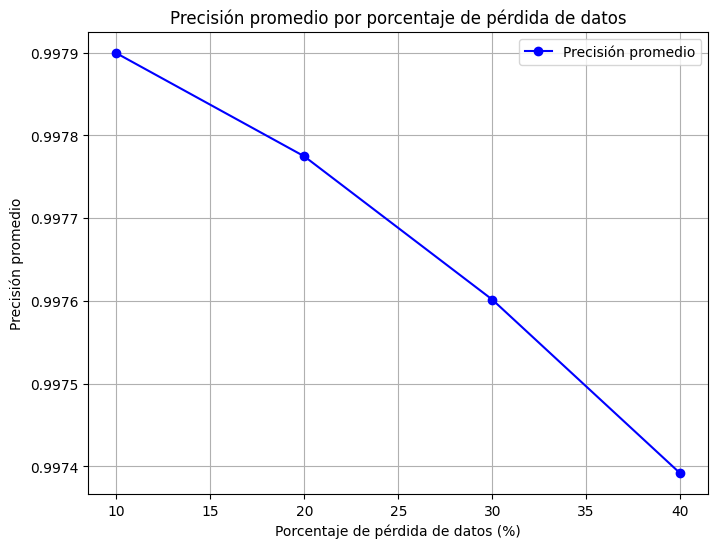

In [15]:
#Se añade un plotting al modelo original
# Extraer los porcentajes y las precisiones promedio del diccionario accuracy_summary
percentages = [perc * 100 for perc in accuracy_summary.keys()]
accuracies = [acc for acc in accuracy_summary.values()]

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(percentages, accuracies, marker='o', linestyle='-', color='b', label='Precisión promedio')

# Personalizar el gráfico
plt.title('Precisión promedio por porcentaje de pérdida de datos')
plt.xlabel('Porcentaje de pérdida de datos (%)')
plt.ylabel('Precisión promedio')
plt.grid(True)
plt.legend()

# Mostrar el gráfico
plt.show()